# Predição de Demanda

Filipe Reis

Este decumento retrata o desenvolvimento da predição de demanda para os produtos listados nos meses de Julho, Agosto e Setembro de 2017. A motivação desse surgiu do desafio criado para a vaga de Data Scientist do Luizalabs. 

Nesse projeto, utilizamos a linguagem Python 3.6 com as seguintes bibliotecas:
    - Pandas: para manipulação dos dados;
    - Matplotlib e Seaborn: para confecção de visualizações;
    - Numpy e Math: para operações matemáticas.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import math

## Análise preliminar

O primeiro passo para analisarmos os dados é carregá-los e notar quais informações temos disponíveis.

In [2]:
orig_file = pd.read_csv('desafio.csv')
print('Original file shape:\n Features:{0}\n Samples:{1}'.format(orig_file.shape[1], orig_file.shape[0] ))
display (orig_file.head(5))

Original file shape:
 Features:14
 Samples:179149


,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


Podemos ver que possuimos 179149 entradas, sendo 14 atributos por entrada. Vejamos agora quantos elementos únicos o conjunto de dados apresenta por categoria.

In [3]:
unique_vals = orig_file.apply(pd.Series.nunique)
print('Unique elements count: \n\n {0}'.format(unique_vals))

Unique elements count: 

 order_id            175575
code                   131
quantity                33
price                23282
pis_cofins           22477
icms                 22027
tax_substitution     10303
category                11
liquid_cost             97
order_status            17
capture_date           366
process_date           372
process_status           2
source_channel          16
dtype: int64


Percebemos claramente que o identificador das compras apresentou uma variação 2% inferior ao total de entradas, o que significa que 98% das vendas reportadas contemplam apenas um produto e 2% um ou mais.
Além disso, vemos 11 categorias distintas, o que pode ser útil para segregar os dados em grupos. 
Por fim, devemos verificar se algum dos atributos apresenta entradas sem informações:

In [4]:
orig_file.isnull().sum().sort_values(ascending=False)

source_channel      0
process_status      0
process_date        0
capture_date        0
order_status        0
liquid_cost         0
category            0
tax_substitution    0
icms                0
pis_cofins          0
price               0
quantity            0
code                0
order_id            0
dtype: int64

Como todas as entradas apresentam informações para todos os atributos, nenhum processamento extra nesse sentido é necessário.

## Pré-processamento dos Dados

Para uso adequado dos algoritmos de separação e classificação, é necessário convertermos as variáveis textuais em categóricas, já que os algoritmos em questão usualmente não são desenvolvidos para aplicações textuais puras. Porém, essa conversão cria a necessidade de cuidado devido aos dados serem categóricos, e não numéricos. Um exemplo disso é que podemos converter as categoriais textuais em números, porém não podemos afirmar que a categoria referente ao número 10 é maior que a ligada ao número 1.

Vamos fazer uma cópia dos dados originais para processá-los mantendo a referência ativa.

In [5]:
processed_data = orig_file
display(processed_data.head(5))

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


### Análises individuais

A categoria status do pedido parece ser irrelevante para nosso propósito. Para confirmar, vejamos quais valores são encontrados nela:

In [6]:
processed_data['order_status'].unique()

array(['entrega total', 'em rota de entrega', 'cancelado',
       'cancelado boleto não pago', 'solicitação de troca', 'processado',
       'solicitação de cancelamento', 'entrega parcial',
       'suspenso barragem', 'cancelado dados divergentes',
       'disponível para retirada.', 'fraude confirmada',
       'cancelado fraude confirmada', 'suspeita de fraude',
       'em rota de devolução', 'pendente processamento',
       'cancelado não aprovado'], dtype=object)

Como as informações contidas nessa variável são referentes a pagamento e entrega dos produtos, não a consideraremos na análise. Outra opção seria a de descartar amostras com status como "fraude confirmada", já que esses casos podem desviar nossas análises da realidade, embora mesmo que essas vendas não sejam finalizadas, o estoque precisa estar disponível da mesma forma.

In [7]:
processed_data.drop('order_status', axis=1, inplace=True)

Em relação à data de realização do pedido, o banco de dados oferece tanto a data de processamento quanto a de captura. Como queremos garantir que o produto esteja em estoque para que possa ser comprado, utilizaremos apenas a data de realização da compra. A data de processamento poderia ser utilizada se quiséssemos, por exemplo, verificar a performance do sistema de vendas e entrega. 

In [8]:
processed_data.drop('process_date', axis=1, inplace=True) 
processed_data.capture_date = pd.to_datetime(processed_data['capture_date'])

Já em relação ao identificador da ordem, poderíamos utilizá-lo para verificar se existem produtos que são sempre comprados em conjunto, logo possuem o mesmo comportamento. 
Porém, tanto o identificador da ordem quanto o código e a categoria são variáveis textuais, então converteremos elas para numéricas categóricas.

In [9]:
processed_data['order_id'] =  pd.Categorical(processed_data['order_id'])
processed_data.order_id = processed_data.order_id.cat.codes
processed_data['code'] =  pd.Categorical(processed_data['code'])
processed_data.code = processed_data.code.cat.codes
processed_data['category'] =  pd.Categorical(processed_data['category'])
processed_data.category = processed_data.category.cat.codes

Outra opção parea lidar com dados categóricos seria criar colunas extras para cada categoria, onde 0 indicaria que o produto não pertence à ela e 1 que pertence. 

In [10]:
#processed_data = pd.get_dummies(processed_data, columns=['category', 'process_status', 'source_channel'])

Para tentarmos extrair mais informação do nosso banco de dados, podemos converter as datas para dias da semana. Esse novo atributo pode agregar informação ao modelo pois podemos ter produtos que são mais comprados em um determiando dia da semana.

In [11]:
processed_data['day_of_week'] = processed_data['capture_date'].dt.dayofweek

Vejamos nosso nossas variáveis resultantes.

In [12]:
display(processed_data.head(5))

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,capture_date,process_status,source_channel,day_of_week
0,129357,124,1,978.90,90.5483,0.0000,191.8416,1,542.7065,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500,5
1,53810,124,1,1036.29,95.8568,176.1693,0.0000,1,542.7065,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500,5
2,93709,124,1,978.90,90.5483,0.0000,191.8416,1,542.7065,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500,6
3,153070,124,1,978.90,90.5483,176.2020,0.0000,1,542.7065,2016-06-13,captado,b76eb9b8fc0f17098812da9117d3e500,0
4,19151,124,1,976.05,90.2846,0.0000,192.3325,1,542.7065,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500,0


## Exploração e Tratamento dos Dados

É provável que cada produto tenha sua característica peculiar, porém uma análise por categoria é muito valiosa, não apenas por representar um comportamento médio, mas também para fornecer uma base para novos produtos. 

### Produto Individual

Vejamos o comportamento de 1 produto isolado:

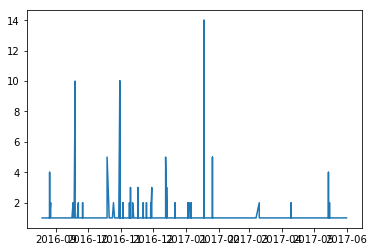

In [13]:
code1 = processed_data[processed_data['code'] == 1]
plt.plot(code1.capture_date, code1.quantity)
plt.show()

Podemos perceber que analisarmos a quantidade de venda com base apenas nos dias em que ocorreram vendas não é muito eficaz. Uma opção melhor é considerar um período de tempo maior, já que assim agregamos mais vendas, afastando a média de vendas do 0. 

### Categoria

Vejamos que tipo de informação a variável categoria pode nos fornecer.

In [14]:
display(processed_data.groupby(['category']).size())

category
0     153943
1         64
2         71
3        200
4       5208
5        330
6      18009
7         58
8        140
9       1053
10        73
dtype: int64

Vemos que a categoria 0 possui muito mais elementos que as demais. Isso pode tanto significar que muitos produtos não estão categorizados ou que essa categoria é de fato muito comum. Vejamos mais informações sobre os produtos considerados por categoria.

In [15]:
for cat, group in processed_data.groupby(['category']):
    g_mean = group.price.mean()
    g_std = group.price.std()
    g_var = g_std / g_mean
    
    print('Category n:{0} \t Sales:{1}\t Different PIDs:{2}\t Mean Price:{3:.2f} \t Std Price:{4:.2f} \t Price Var.:{5:.2f}'.format(
                                                cat, group.shape[0], group.code.nunique(), g_mean, g_std, g_var))

Category n:0 	 Sales:153943	 Different PIDs:106	 Mean Price:224.28 	 Std Price:156.88 	 Price Var.:0.70
Category n:1 	 Sales:64	 Different PIDs:2	 Mean Price:847.40 	 Std Price:292.37 	 Price Var.:0.35
Category n:2 	 Sales:71	 Different PIDs:2	 Mean Price:844.85 	 Std Price:95.21 	 Price Var.:0.11
Category n:3 	 Sales:200	 Different PIDs:1	 Mean Price:26.39 	 Std Price:7.31 	 Price Var.:0.28
Category n:4 	 Sales:5208	 Different PIDs:8	 Mean Price:553.18 	 Std Price:424.41 	 Price Var.:0.77
Category n:5 	 Sales:330	 Different PIDs:3	 Mean Price:159.51 	 Std Price:107.61 	 Price Var.:0.67
Category n:6 	 Sales:18009	 Different PIDs:2	 Mean Price:228.69 	 Std Price:208.22 	 Price Var.:0.91
Category n:7 	 Sales:58	 Different PIDs:1	 Mean Price:74.31 	 Std Price:33.74 	 Price Var.:0.45
Category n:8 	 Sales:140	 Different PIDs:1	 Mean Price:7.68 	 Std Price:1.41 	 Price Var.:0.18
Category n:9 	 Sales:1053	 Different PIDs:2	 Mean Price:313.11 	 Std Price:305.95 	 Price Var.:0.98
Category n:10 

Podemos perceber que a variação nos preços para quase todas as categorias é bem alta. Isso pode tanto indicar que essas categorias não separam produtos por classes quanto que esses índices segregam as mercadorias por classe mas em uma mesma classe temos produtos muito diferentes. Um exemplo disso seria uma máquina de lavar, que pode custar tanto 700 quanto 7000 reais.

### Agrupamento por meses

Como nossas previsões serão baseadas em vendas mensais, podemos converter as entradas individualmente consideradas para vendas ao longo de meses. Para tanto, confirmemos quais meses estão representados no banco de dados.

In [16]:
for month, group in processed_data.groupby([processed_data['capture_date'].dt.year, processed_data['capture_date'].dt.month]):
    print(month)

(2016, 6)
(2016, 7)
(2016, 8)
(2016, 9)
(2016, 10)
(2016, 11)
(2016, 12)
(2017, 1)
(2017, 2)
(2017, 3)
(2017, 4)
(2017, 5)
(2017, 6)


Vemos que nossa base de dados contém vendas para desde junho de 2016 até o mesmo mês de 2017. Agora, podemos agrupar as amostras por meses.

In [ ]:
def convert_group2line(group, code):
    monthly_data = group.groupby([processed_data['capture_date'].dt.year, processed_data['capture_date'].dt.month])
    adjusted_data = []
    
    for month, group in monthly_data:
        quantity = group.quantity.sum()
        price = group.price.mean()
        category = group.category.mean()
        liquid_cost = group.liquid_cost.mean()
        common_day = group.day_of_week.value_counts().idxmax()
        
        month_data = {'capture_date':month,'code': code, 'quantity':quantity, 'price': price, 
                      'category':category, 'liquid_cost':liquid_cost, 'common_day': common_day }
        
        adjusted_data.append(month_data)
    
    adjusted_data = pd.DataFrame(adjusted_data)
    
    return(adjusted_data)

monthly_results = pd.DataFrame()

for product_id in range(processed_data.code.min(),  processed_data.code.max() + 1 ):
    #print('Completed:{0:.2f}%'.format(100*(product_id/(processed_data.code.max() + 1))))

    grouped_id = processed_data[processed_data.apply(lambda x: x['code'] == product_id, axis=1)]
    product_line = convert_group2line(grouped_id, product_id)
    monthly_results = monthly_results.append(product_line, ignore_index = True)

monthly_results.to_csv('monthly_results.csv', index=False)


In [17]:
monthly_results = pd.read_csv('monthly_results.csv')
monthly_results.capture_date = (pd.to_datetime(monthly_results.capture_date, format='(%Y, %m)'))
display(monthly_results.head(5))

,capture_date,category,code,common_day,liquid_cost,price,quantity
0,2016-11-01,0.0,0,4,117.082,209.098118,881
1,2016-12-01,0.0,0,0,117.082,256.597658,283
2,2017-01-01,0.0,0,5,117.082,215.608560,389
3,2017-02-01,0.0,0,1,117.082,205.569618,1059
4,2017-03-01,0.0,0,2,117.082,201.265021,2157


Com os dados já considerados em base mensal, podemos desenhar os gráficos de vendas de alguns produtos no período considerado para confirmarmos que a transformação transcorreu com sucesso.

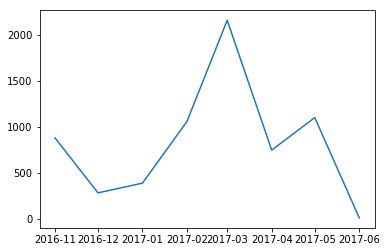

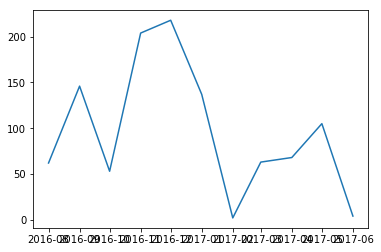

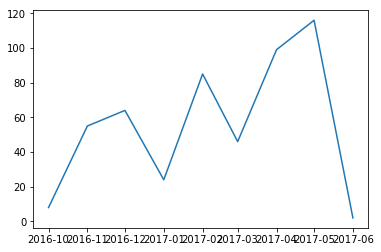

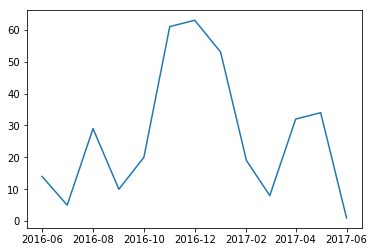

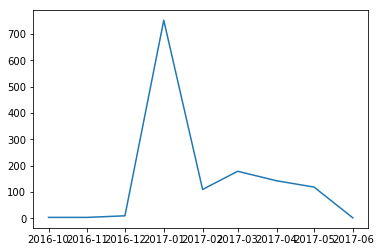

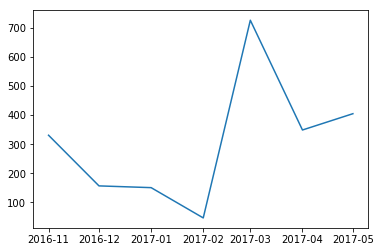

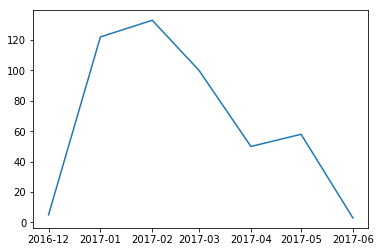

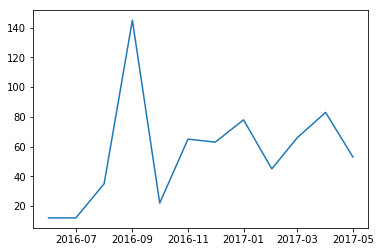

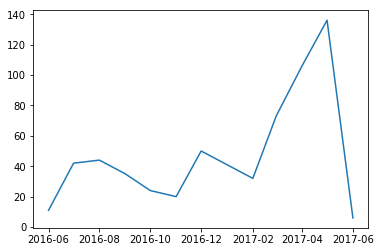

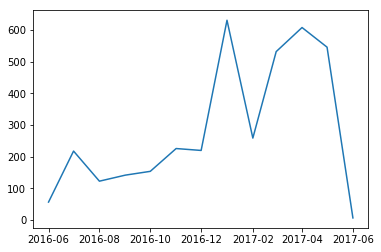

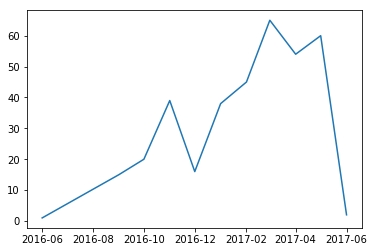

In [18]:
for n in range (0, 11):
    code1 = monthly_results[monthly_results['code'] == n]
    plt.plot(code1.capture_date, code1.quantity)
    plt.show()

Em todos os gráficos desenhados, vemos uma queda acentuada nas vendas para o mês 6 de 2017. Esse comportamento está relacionado ao fato de tal mês não ser representado em sua integridade. Uma opção para lidar com isso seria reprocessar as vendas com base no número de dias de cada mês, obtendo valores médios de vendas por dias. Porém a opção utilizada será desconsiderar o mês em questão por simplicidade. 

In [19]:
#drops 06 as its not a full month
monthly_results = monthly_results[monthly_results['capture_date'] != pd.to_datetime('2017-06-01')]

Dependendo dos algoritmos de segregação e predição que formos utilizar, pode ser necessário tratarmos dos produtos que apresentam meses sem vendas, já que isso pode ter ocorrido tanto por ausência real de vendas desses produtos quanto por problemas na hora de criar o conjunto de dados original. Apesar de possuirmos muitas opções e ser uma decisão difícil, caso um produto não tenha entrada em um dado mês, a média (tanto para preço e custo quanto para quantidade) em todo o período será inserida para o mesmo

In [20]:
period = []
dates = ['(2016, 8)', '(2016, 9)', '(2016, 10)', '(2016, 11)', '(2016, 12)', '(2017, 1)', '(2017, 2)', '(2017, 3)', '(2017, 4)', '(2017, 5)']

for date in dates:
    period.append(pd.to_datetime(date, format='(%Y, %m)' ))

period = pd.to_datetime(period, format='(%Y, %m)')

complete = pd.DataFrame()

for product_id in range(monthly_results.code.min(),  monthly_results.code.max() + 1):
    grouped_id = monthly_results[monthly_results.apply(lambda x: x['code'] == product_id, axis=1)]
    for month in period.values:
        if month in grouped_id.capture_date.unique() :
            pass
        else:
            missing = {'capture_date':month, 'category':grouped_id.category.max(), 'code': grouped_id.code.max(), 
                       'common_day':grouped_id.common_day.max(),'liquid_cost':grouped_id.liquid_cost.mean(), 
                       'price':grouped_id.price.mean(), 'quantity': grouped_id.quantity.mean()}
            grouped_id = grouped_id.append(missing, ignore_index=True)
    complete = complete.append(grouped_id, ignore_index = True)

display(complete.head(5))
complete.to_csv('complete.csv')


,capture_date,category,code,common_day,liquid_cost,price,quantity
0,2016-11-01,0.0,0,4,117.082,209.098118,881.0
1,2016-12-01,0.0,0,0,117.082,256.597658,283.0
2,2017-01-01,0.0,0,5,117.082,215.608560,389.0
3,2017-02-01,0.0,0,1,117.082,205.569618,1059.0
4,2017-03-01,0.0,0,2,117.082,201.265021,2157.0


Como a venda de muitos produtos pode estar muito relacionada ao seu preço, é interessante adicionarmos parâmetros de correlação entre preço e unidades vendidas. Além disso, também podemos inserir informações sobre a correlação entre o dia da semana em que a venda foi mais recorrente com o número de vendas. 

In [21]:
features =[]
for product_id in range(monthly_results.code.min(),  monthly_results.code.max() + 1 ):
    
    grouped_id = monthly_results[monthly_results.apply(lambda x: x['code'] == product_id, axis=1)]
    price_corr = grouped_id.price.corr(grouped_id.quantity)
    common_day_corr = grouped_id.common_day.corr(grouped_id.quantity)
    #print('> completed:{0:.2f}'.format(product_id/(monthly_results.code.max() + 1)))
    result = {'code': product_id, 'price_corr': price_corr,'common_day_corr': common_day_corr}
    features.append(result)

features = pd.DataFrame(features)

display(features.head(5))

,code,common_day_corr,price_corr
0,0,-0.160963,-0.660029
1,1,0.546023,-0.165227
2,2,-0.916250,-0.757843
3,3,0.044974,0.371437
4,4,0.155450,-0.206817


## Segmentação dos dados
Para realizarmos a segmentação dos dados em grupos, é importante entendermos que o comportamento das vendas dos mesmos pode ser relacionado por uma série temporal. Tal série temporal mostra claramente um comportamento sazonal, porém não mostra tão bem uma alta correlação com o preço. Portanto, precisamos utilizar todos os atributos que já discutimos para fazer a segregação. Logo, precisamos apenas calcular a semelhança entre as séries temporais para termos todos os elementos de separação.

### Segregação de Séries Temporais

Para diferenciarmos os produtos em seus comportamentos temporais, podemos utilizar algumas estratégias, das quais duas se destacam:
    - Cálculo das diferenças entre as vendas dos produtos para séries alinhadas: nesse caso, precisamos utilizar os dados com os meses sem dados compostos pelas médias, conforme fizemos anteriormente. A vantagem desse método é que cobrimos eventuais erros na aquisição dos dados, sendo que a desvantagem é que se esses vazios não forem erros, teremos resultados acima do real. Para sse método, podemos utilizar o cálculo pelo algoritmo de k-vizinhos mais próximos, disponível na biblioteca scikit-learn;
    - Cálculo das diferenças entre as vendas dos produtos para séries desalinhadas:  com essa estratégia não precisamos compensar pelos meses que faltam. Essa estratégia utiliza um método de Dynamic Time Warping.
Após calcular as diferenças entre as séries, podemos seprar em conjutos as séries com maior semelhança, ou seja, processamos os resultados das distâncias e agrupamos os produtos cujas distâncias entre si sejam as menores;
    - Uso de HMM(Hidden-Markov-Models: modelos escondidos de markov): essa estratégia é geralmente utilizada para segregar e classificar estruturas intrinsicamente conectadas a linguagens, porém pode ser aplicada para séries temporais, já que é capaz de mapear muito bem transições de estados e comportamentos recorrentes. Essa técnica funciona criando um modelo probabilístico composto por diversos estados, onde atributos do fenômeno observado fazem com que o modelo transite de um estado para outro, até que todos os atributos sejam considerados e um resultado obtido. 

Para todas as estratégias, é importante normalizarmos as quantidades de venda antes da aplicação. Fazendo isso, nosso algoritmo será capaz de identificar semelhanças entre produtos que, embora igualmente sazonais, tenham números absolutos de vendas muito distintos.

Apesar de todas as estratégias serem válidas, nesse trabalho consideraremos a utilizando Dynamic Time Warping.

In [22]:
distances_global =[]
#for product_id in range(complete.code.min(), complete.code.max() + 1 ):
    #distances_prod = []
    #grouped_id = complete[complete.apply(lambda x: x['code'] == product_id, axis=1)]
    #should run in parallel
    #for other in range(complete.code.min(), complete.code.max() + 1 ):
        #if other != product_id:#should nest
            #grouped_other = complete[complete.apply(lambda x: x['code'] == other, axis=1)]
            #distances_prod.append(DTWDistance(grouped_id.quantity.tolist(),grouped_other.quantity.tolist() ))
    #distances_global.append(distances_prod)

Com os grupos devidamente segregados, podemos utilizar o algoritmo de Clusterização Aglomerativa disponível na biblioteca Scikit-learn(http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) para considerar nosso conjunto de atributos. 